#Student Dropout Prediction

---


# Introduction  

School dropout and educational failure pose significant challenges to economic growth and societal well-being, directly impacting students, families, institutions, and the broader community. According to the [Education Data Initiative](https://educationdata.org/college-dropout-rates#:~:text=Report%20Highlights.,Enrollment%20Statistics%20%7C%20Financial%20Aid%20Statistics), around 40% of undergraduate students in the United States drop out before completing their degrees. College dropouts face more financial challenges, earning an average of 35% less income and experiencing a 20% higher unemployment rate compared to their peers who graduate.  

In this project, We aim to build a classification model to predict student dropout and identify which students need more support to prevent them from dropping out. We will address the following questions:  

* What are the factors which contribute to student dropout, and how do they impact it?  
* Which students are most in need of support to stay in school?   

**Data**

The dataset contains 4,424 records with 35 attributes, where each record represents an individual student. It includes information available at the time of student enrollment, along with demographic, socioeconomic, and macroeconomic data, as well as the students’ academic performance at the end of the first and second semesters.

In [2]:
# Import important packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing and EDA
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency

In [3]:
# Load data

file_id = "18iiWxXMNV3tBgjpTshq3kOqiH1CLnD4U"
download_url = f"https://drive.google.com/uc?id={file_id}"

# Read the CSV file directly from the URL
students = pd.read_csv(download_url)

# Check the data
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

#Data Cleaning

This dataset is nearly clean thanks to the rigorous data preprocessing performed by the contributors of the [data](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention).

However, a few minor cleaning steps are still needed. First, I'll modify some column names to make them more consistent and easier to work with later and check if there are any missing values

In [4]:
students.isnull().sum()

,0
Marital status,0
Application mode,0
Application order,0
Course,0
Daytime/evening attendance,0
Previous qualification,0
Nacionality,0
Mother's qualification,0
Father's qualification,0
Mother's occupation,0


In [5]:
students.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [6]:
# Correct a column name that has a typo and replace single quotes with underscores
students.rename(columns = {"Nacionality": "Nationality",
                           "Mother's qualification": "Mother_qualification",
                           "Father's qualification": "Father_qualification",
                           "Mother's occupation": "Mother_occupation",
                           "Father's occupation": "Father_occupation",
                           "Age at enrollment": "Age"}, inplace = True)

# Replace white space in the column names with underscore
students.columns = students.columns.str.replace(' ', '_')

# Remove the parenthesis
students.columns = students.columns.str.replace('(', '')
students.columns = students.columns.str.replace(')', '')

I'll change the data types of columns that should be categorical from ‘int’ to ‘category’ to ensure that classification models treat these columns as categorical data rather than numerical.

In [7]:
# Change data types of columns that should be categorical
col = ['Marital_status', 'Application_mode', 'Application_order', 'Course',
      'Daytime/evening_attendance', 'Previous_qualification', 'Nationality',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
      'International', 'Target']

students[col] = students[col].astype('category')

In [8]:
students.head(10)

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Nationality,Mother_qualification,Father_qualification,Mother_occupation,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
5,2,12,1,17,0,12,1,22,27,10,...,0,5,17,5,11.500000,5,16.2,0.3,-0.92,Graduate
6,1,1,1,12,1,1,1,13,28,8,...,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
7,1,9,4,11,1,1,1,22,27,10,...,0,5,5,0,0.000000,0,15.5,2.8,-4.06,Dropout
8,1,1,3,10,1,1,15,1,1,10,...,0,6,7,6,14.142857,0,16.2,0.3,-0.92,Graduate
9,1,1,1,10,1,1,1,1,14,5,...,0,6,14,2,13.500000,0,8.9,1.4,3.51,Dropout


In [9]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Marital_status                                4424 non-null   category
 1   Application_mode                              4424 non-null   category
 2   Application_order                             4424 non-null   category
 3   Course                                        4424 non-null   category
 4   Daytime/evening_attendance                    4424 non-null   category
 5   Previous_qualification                        4424 non-null   category
 6   Nationality                                   4424 non-null   category
 7   Mother_qualification                          4424 non-null   category
 8   Father_qualification                          4424 non-null   category
 9   Mother_occupation                             4424 n

#Exploratory Data Analysis

There are 34 features in this dataset. I will examine their relationship with the target variable, which is a three-class categorical data. The features that have no association with the label will be the potential variables to be removed from modeling.



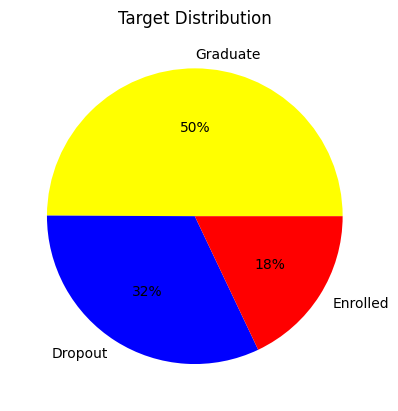

In [11]:
# Check the proportion of the labels(dropout, enrolled, and graduate) in the target variable
labels = students['Target'].value_counts().index
values = students['Target'].value_counts().values

plt.pie(values, labels = labels, colors = ['yellow', 'blue', 'red'],
        autopct = '%1.0f%%')
plt.title('Target Distribution');

From the pie chart above we can see that the data is imbalanced: with about 50% of the labels are 'Graduate', 32% are 'Dropout', and 18% are 'Enrolled'.

The labels are string, I will encode them as ordinal data -- 0 represents 'Dropout', 1 represents 'Enrolled', and 2 represents 'Graduate' -- since most classification models only handle numeric values.

In [12]:
# Encode the labels as ordinal data (0 - 'Dropout', 1 - 'Enrolled', and 2 - 'Graduate')
students['Target_encoded'] = OrdinalEncoder(categories = [['Dropout', 'Enrolled', 'Graduate']]).fit_transform(students[['Target']])

# Drop 'Target' variable
students.drop('Target', axis = 1, inplace = True)

In [13]:
students['Target_encoded'].value_counts(normalize=True)*100

,proportion
Target_encoded,
2.0,49.932188
0.0,32.120253
1.0,17.947559


The encoded labels are matching with the proportion pie chart above. We are good to go ahead.

##Categorical Feature Analysis


###Univariate Analysis - Let's understand the distribution of each categories through count plots

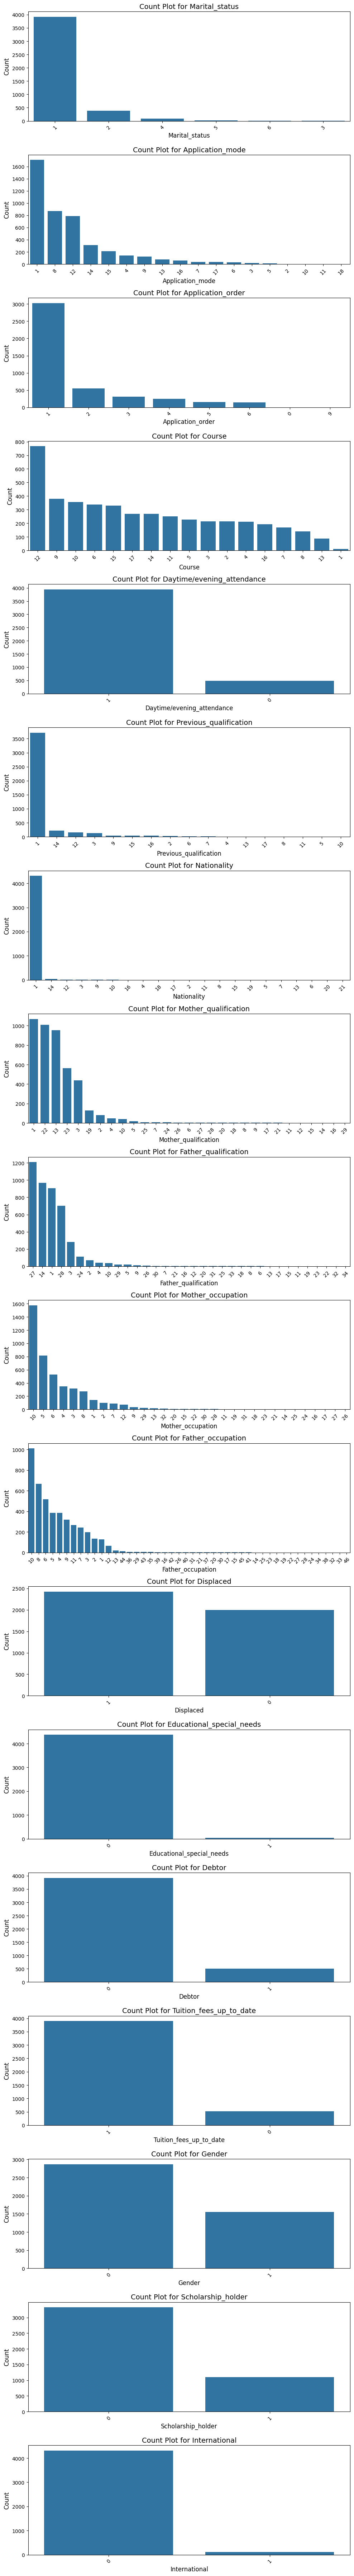

In [14]:
# Univariate Analysis
# Select categorical features
categorical_features = students.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Set figure size depending on number of plots
plt.figure(figsize=(10, len(categorical_features) * 4))

# Loop through categorical features and plot them vertically
for i, col in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.countplot(data=students, x=col, order=students[col].value_counts().index)
    plt.title(f'Count Plot for {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


1) Marital Status is heavily skewed toward one group, which may reduce its impact unless the minority classes have distinct dropout patterns.

2) Application Mode and Order show clear preference for a few categories. These could signal motivation or institutional processes and might be useful predictors.

3) Course shows a broad distribution, which is promising—it could help the model differentiate dropout risk across programs.

4) Daytime/Evening Attendance is mostly daytime, but evening students might represent a unique group (e.g., working students), possibly influencing outcomes.

5) Previous Qualification and Nationality have low variability, especially nationality, which may limit their predictive power.

6) Parental Education and Occupation have high cardinality and long tails. They might capture socioeconomic factors if grouped smartly.

7) Displaced, Special Needs, Debtor, and Tuition Fees are binary and imbalanced, but they likely capture key risk factors—especially financial-related ones.

8) Gender, Scholarship Holder, and International Status are slightly imbalanced. Their usefulness will depend on how they interact with other features.

9) Overall, I’ll revisit these after initial model runs to evaluate their importance and decide if any features need transformation, grouping, or exclusion.

###Bivariate Analysis - Chi-Square Independence Test for Categorical Variables

The Chi-Square independence test will be implemented to check the association between the categorical variables and the dependent variable, with the hypothesis as follows:  

$H_{0}$: the two variables are independent  
$H_{1}$: the two variables are dependent  

$\alpha$ = 0.05

I will reject the null hypothesis and accept the alternative hypothesis if the p-value is less than 0.05, meaning the two variables are dependent. If the p-value is greater than or equal to 0.05, I fail to reject the null hypothesis, meaning the two variables are independent.

In [ ]:
# list of categorical features
cats = ['Marital_status', 'Application_mode', 'Application_order',
        'Course','Daytime/evening_attendance', 'Previous_qualification',
        'Nationality','Mother_qualification', 'Father_qualification',
        'Mother_occupation', 'Father_occupation', 'Displaced',
        'Educational_special_needs', 'Debtor','Tuition_fees_up_to_date',
        'Gender', 'Scholarship_holder','International']

# Get the p-values from Chi-Square indenpendence tests
p_value = []

for col in cats:
    crosstable = pd.crosstab(index = students[col],
                             columns = students['Target_encoded'])
    p = chi2_contingency(crosstable)[1]
    p_value.append(p)

chi2_result = pd.DataFrame({
    'Variable': cats,
    'P_value': [round(ele, 5) for ele in p_value]
})

chi2_result = chi2_result.sort_values('P_value')

chi2_result

,Variable,P_value
0,Marital_status,0.00000
1,Application_mode,0.00000
2,Application_order,0.00000
3,Course,0.00000
4,Daytime/evening_attendance,0.00000
5,Previous_qualification,0.00000
7,Mother_qualification,0.00000
8,Father_qualification,0.00000
13,Debtor,0.00000
9,Mother_occupation,0.00000


Most of the p-values are close to zero, except for three variables ('Nationality', 'International', 'Educational_special_needs') with very high p-values (0.24, 0.53, 0.73), indicating that no statistically significant association between these three features and the label. I will exclude them from modeling.

**We used the Chi-Square test to evaluate the dependence of categorical features on the target variable. Since this test is only applicable to categorical variables, we now proceed to explore the numerical features using appropriate techniques.**

In [ ]:
stud_selected = students.drop(['Nationality', 'International', 'Educational_special_needs'],
                              axis = 1)

##Numerical Feature Analysis
###Estimates of Location and Variability

In [ ]:
students.describe()

,Age,Curricular_units_1st_sem_credited,Curricular_units_1st_sem_enrolled,Curricular_units_1st_sem_evaluations,Curricular_units_1st_sem_approved,Curricular_units_1st_sem_grade,Curricular_units_1st_sem_without_evaluations,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Target_encoded
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,23.265145,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,1.178119
std,7.587816,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,0.888243
min,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,0.000000
25%,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,0.000000
50%,20.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,1.000000
75%,25.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,2.000000
max,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000,2.000000


Looking at Age, Curricular_units_1st_sem_credited and Curricular_units_1st_sem_enrolled, its evident that there are outliers in the data.

Age - 75% quartile is up-to 25 and max is 70 years of age, which is a huge jump.

Curricular_units_1st_sem_credited - 75% quartile is up-to 0 and max is at 20 credits, which is a huge jump. Similarly it is same with Curricular_units_1st_sem_enrolled.

###Univariate Analysis - Histograms to visualise the distribution of numerical feature

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


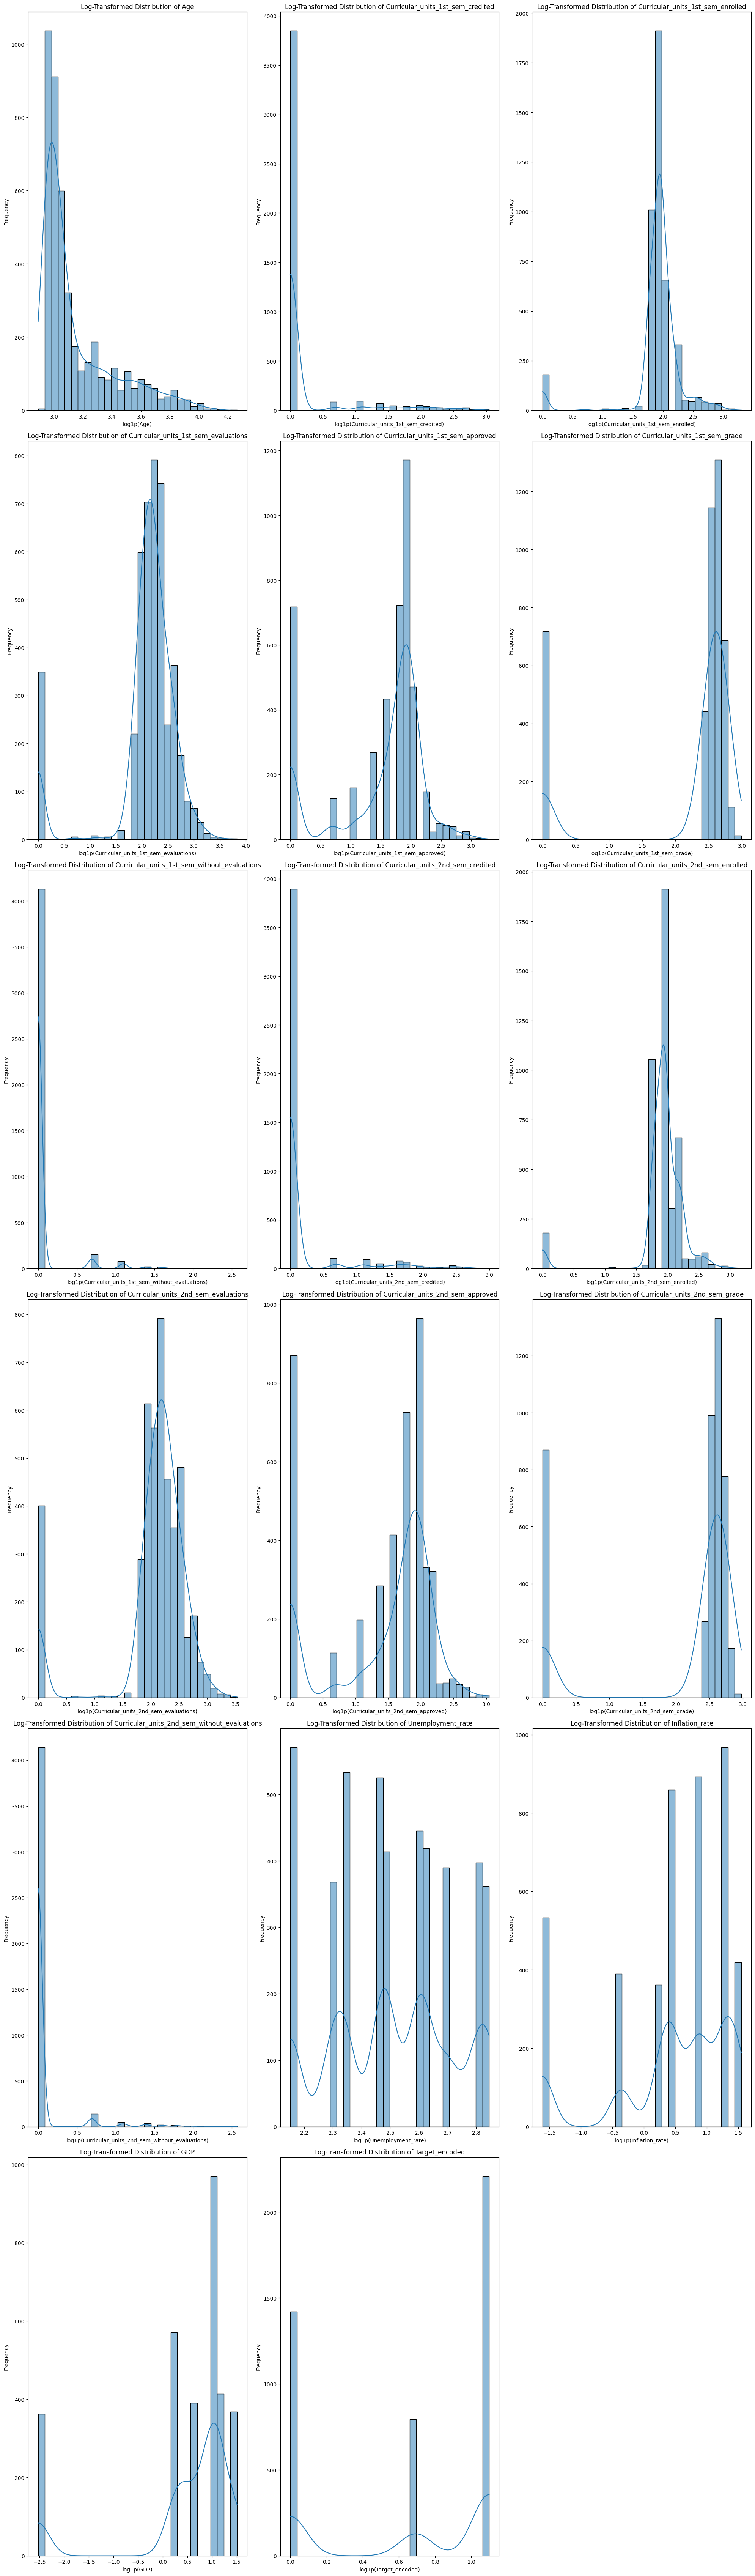

In [ ]:
#Histogram - Univariate Analysis(log transformed)
numerical_cols = students.select_dtypes(include=['int64', 'float64']).columns

# Set up the plot
plt.figure(figsize=(20, len(numerical_cols) * 4))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot((len(numerical_cols) + 2) // 3, 3, i)

    # Apply log transformation safely
    log_data = np.log1p(students[col])  # log1p = log(1 + x), safe for zero values

    sns.histplot(log_data, kde=True, bins=30)
    plt.title(f'Log-Transformed Distribution of {col}')
    plt.xlabel(f'log1p({col})')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Looking at these log-transformed histograms, I can tell that a lot of the data was originally skewed — probably with long tails or a lot of zeros. After applying the log transformation, the shapes of the distributions look a lot more normalized or at least smoothed out.

1) Age: has a right skew originally, but the log transformation helped compress the extreme values. Now, I can clearly see that most students fall into a narrow age band.

2) Curricular Units (1st & 2nd Sem): For things like curricular_units_1st_sem_approved, grade, evaluations, and similar for the 2nd semester, I see clear peaks and groupings. The log scale helped reveal subtleties, like small groups with low or zero completions or grades. Some of the variables still have sharp peaks — maybe a lot of students scored zeros or maxed out the units.

3) Unemployment Rate & Inflation: These were categorical or rounded values originally, so even after log-transforming, they still look like bar charts. They seem to cluster around specific national benchmarks, which might reflect broader economic conditions.

In [ ]:
# Make a copy of your original dataframe (For logistics regression model if necessary)
log_transformed_students = students.copy()
numerical_cols = students.select_dtypes(include=['int64', 'float64']).columns

# Track saved log-transformed columns
log_transformed_cols = []

for col in numerical_cols:
    min_val = students[col].min()

    if min_val < 0:
        shift = abs(min_val) + 1
        log_transformed_students[col + '_log'] = np.log1p(students[col] + shift)
        print(f"Shifted and log-transformed '{col}' by +{shift}")
    else:
        log_transformed_students[col + '_log'] = np.log1p(students[col])
        print(f"Log-transformed '{col}' without shift")

    log_transformed_cols.append(col + '_log')

# ✅ Display all saved log-transformed columns
print("\nAll log-transformed columns:")
for col in log_transformed_cols:
    print(col)


Log-transformed 'Age' without shift
Log-transformed 'Curricular_units_1st_sem_credited' without shift
Log-transformed 'Curricular_units_1st_sem_enrolled' without shift
Log-transformed 'Curricular_units_1st_sem_evaluations' without shift
Log-transformed 'Curricular_units_1st_sem_approved' without shift
Log-transformed 'Curricular_units_1st_sem_grade' without shift
Log-transformed 'Curricular_units_1st_sem_without_evaluations' without shift
Log-transformed 'Curricular_units_2nd_sem_credited' without shift
Log-transformed 'Curricular_units_2nd_sem_enrolled' without shift
Log-transformed 'Curricular_units_2nd_sem_evaluations' without shift
Log-transformed 'Curricular_units_2nd_sem_approved' without shift
Log-transformed 'Curricular_units_2nd_sem_grade' without shift
Log-transformed 'Curricular_units_2nd_sem_without_evaluations' without shift
Log-transformed 'Unemployment_rate' without shift
Shifted and log-transformed 'Inflation_rate' by +1.8
Shifted and log-transformed 'GDP' by +5.06
Log-

###Bivariate Analysis - Spearman's rank correlation between numerical features and the Target

A heatmap is used to visualize the Spearman's rank correlation between numerical features and the labels. Spearman's rank correlation measures the strength and direction of monotonic association between two variables. It can capture both linear and nonlinear monotonic relationships.

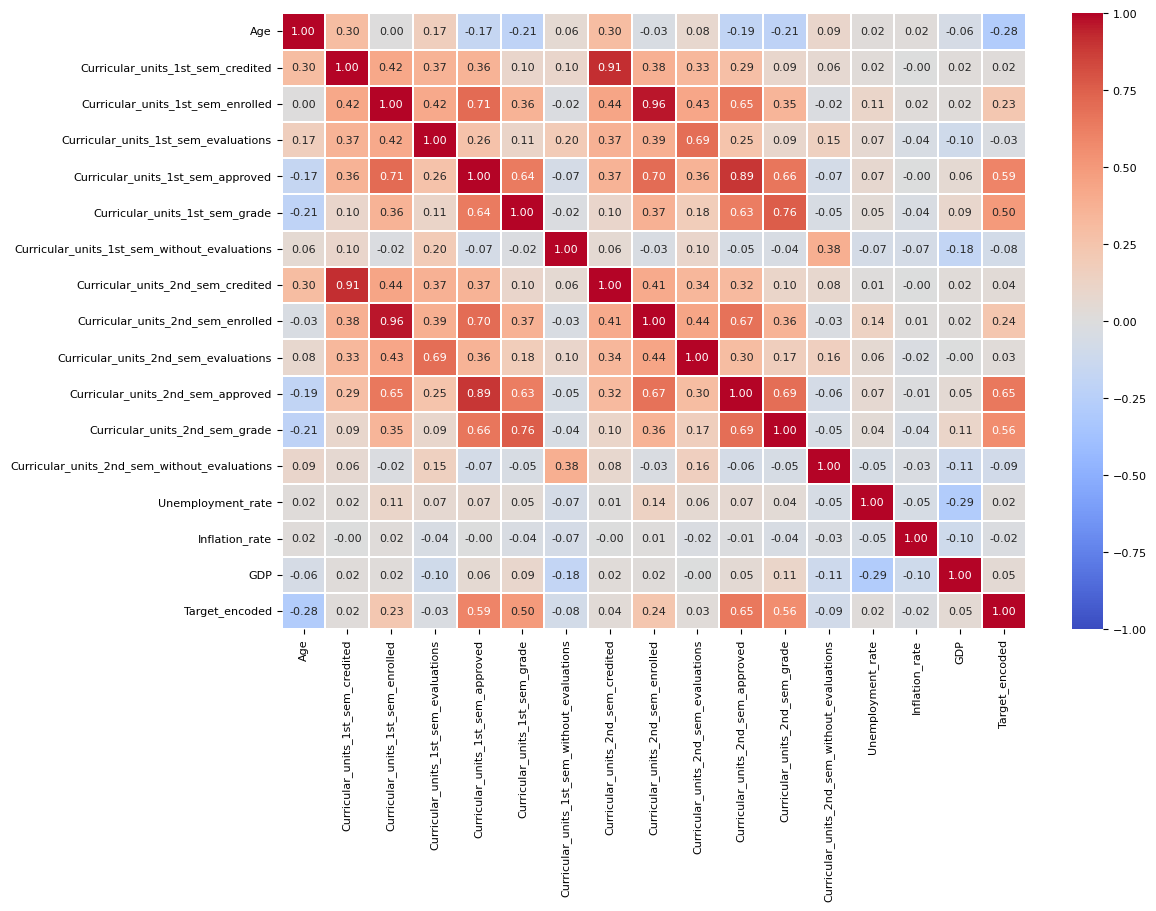

In [ ]:
# Numeric features
num_features = students[['Age',
       'Curricular_units_1st_sem_credited',
       'Curricular_units_1st_sem_enrolled',
       'Curricular_units_1st_sem_evaluations',
       'Curricular_units_1st_sem_approved',
       'Curricular_units_1st_sem_grade',
       'Curricular_units_1st_sem_without_evaluations',
       'Curricular_units_2nd_sem_credited',
       'Curricular_units_2nd_sem_enrolled',
       'Curricular_units_2nd_sem_evaluations',
       'Curricular_units_2nd_sem_approved',
       'Curricular_units_2nd_sem_grade',
       'Curricular_units_2nd_sem_without_evaluations',
       'Unemployment_rate', 'Inflation_rate', 'GDP', 'Target_encoded']]

# Heatmap of correlation matrix
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 8})
hm = sns.heatmap(num_features.corr(method = 'spearman'),
                 cmap = 'coolwarm', annot = True, fmt = '.2f',
                 linewidths = .2, vmin = -1, vmax = 1, center = 0)

As can be seen from the heat map, there are four features ('Curricular_units_2nd_sem_approved’, 'Curricular_units_2nd_sem_grade’, ’Curricular_units_1st_sem_approved’, 'Curricular_units_1st_sem_grade’) that have relatively high and positive correlations with the label, while some have very low correlations(e.g., 'Unemployment_rate', 'Inflation_rate')

The heat map also reveals multicollinearity among the features related to curricular units. These features represent students' academic performance at the end of the first and second semesters. I will aggregate them to get the average value between the two semesters.

In [ ]:
# Averaging academic performance data across two semesters
stud_selected['avg_credited'] = stud_selected[['Curricular_units_1st_sem_credited',
                                'Curricular_units_2nd_sem_credited']].mean(axis = 1)
stud_selected['avg_enrolled'] = stud_selected[['Curricular_units_1st_sem_enrolled',
                                'Curricular_units_2nd_sem_enrolled']].mean(axis = 1)
stud_selected['avg_evaluations'] = stud_selected[['Curricular_units_1st_sem_evaluations',
                                   'Curricular_units_2nd_sem_evaluations']].mean(axis = 1)
stud_selected['avg_approved'] = stud_selected[['Curricular_units_1st_sem_approved',
                                'Curricular_units_2nd_sem_approved']].mean(axis = 1)
stud_selected['avg_grade'] = stud_selected[['Curricular_units_1st_sem_grade',
                             'Curricular_units_2nd_sem_grade']].mean(axis = 1)
stud_selected['avg_without_evaluations'] = stud_selected[['Curricular_units_1st_sem_without_evaluations',
                                           'Curricular_units_2nd_sem_without_evaluations']].mean(axis = 1)

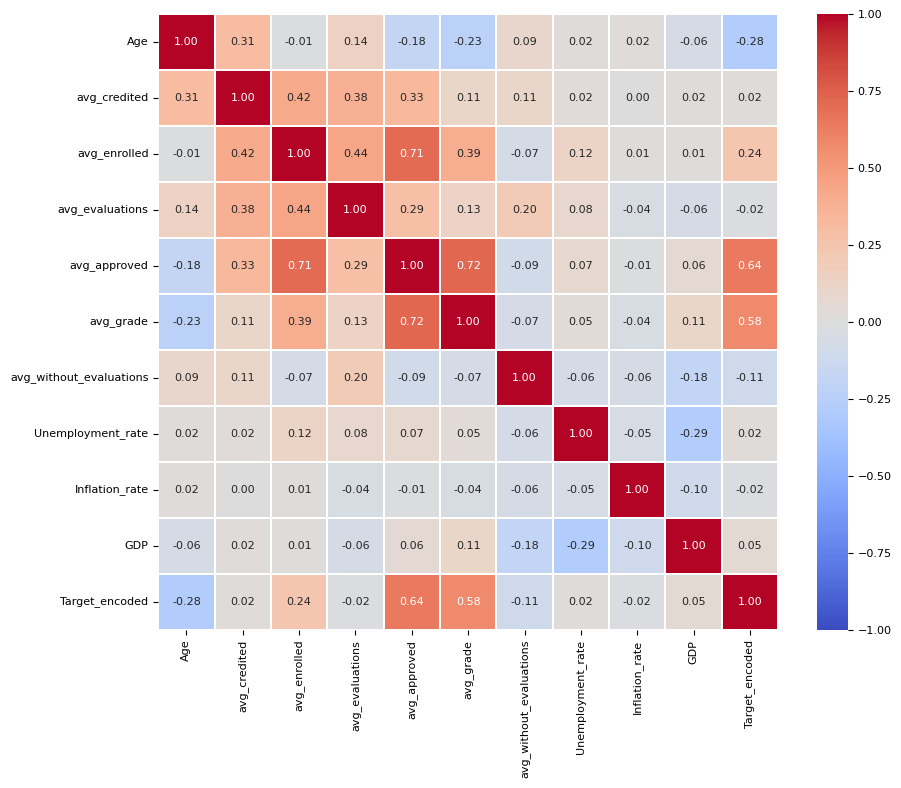

In [ ]:
# plot the heat map of correlation matrix again
num_features = stud_selected[['Age', 'avg_credited', 'avg_enrolled',
                              'avg_evaluations', 'avg_approved',
                              'avg_grade', 'avg_without_evaluations',
                              'Unemployment_rate', 'Inflation_rate',
                              'GDP', 'Target_encoded']]

plt.figure(figsize = (10, 8))
plt.rcParams.update({'font.size': 8})
sns.heatmap(num_features.corr(method = 'spearman'), vmin = -1, vmax = 1, center = 0,
            cmap = 'coolwarm', fmt = '.2f', linewidths = .2, annot = True);

The new correlation matrix above shows that 'curri_avg_approved' and 'curri_avg_grade' still have a relatively high correlation with the labels ('Target_encoded'), while 'curri_avg_credited' and 'curri_avg_evaluations', along with 'the macroeconomic data ('Unemployment_rate', 'Inflation_rate'), have very low correlations, all between -0.02 and 0.02. I will exclude these four features.

The multicollinearity still exists among the academic data. I'll take it into account when selecting the models.

Let's check how 'curri_avg_approved' and 'curri_avg_grade' are associated with students' situation at the end of the normal duration of the course.

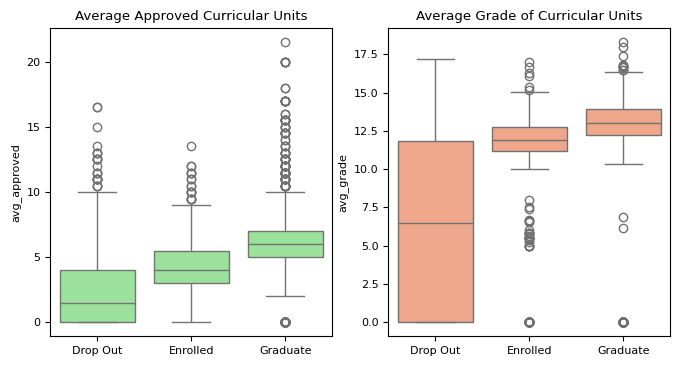

In [ ]:
# Plot 'avg_approved' and 'avg_grade' vs. Target
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
sns.boxplot(data = stud_selected, x = 'Target_encoded', y = 'avg_approved',
            color = 'lightgreen', ax = ax1)
ax1.set_title('Average Approved Curricular Units')
ax1.set_xlabel("")
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Drop Out', 'Enrolled', 'Graduate']);

sns.boxplot(data = stud_selected, x = 'Target_encoded', y = 'avg_grade',
            color = 'lightsalmon', ax = ax2)
ax2.set_title('Average Grade of Curricular Units')
ax2.set_xlabel("")
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Drop Out', 'Enrolled', 'Graduate']);

It's not surprising that 'Graduate' is associated with more approved curricular units and higher grades. However, there are some instances of a 0 value for average grade and average approved curricular units in the 'Graduate' class.

In [ ]:
# Check the rows with zero average approved curricular units and students being graduade
stud_selected.loc[(stud_selected['avg_approved'] == 0) & (stud_selected['Target_encoded'] == 2)]

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Mother_qualification,Father_qualification,Mother_occupation,Father_occupation,...,Unemployment_rate,Inflation_rate,GDP,Target_encoded,avg_credited,avg_enrolled,avg_evaluations,avg_approved,avg_grade,avg_without_evaluations
20,1,1,3,2,1,1,1,1,10,9,...,11.1,0.6,2.02,2.0,0.0,0.0,0.0,0.0,0.0,0.0
66,1,1,3,2,1,1,13,14,6,4,...,10.8,1.4,1.74,2.0,0.0,0.0,0.0,0.0,0.0,0.0
101,1,1,4,2,1,1,1,1,10,11,...,16.2,0.3,-0.92,2.0,0.0,0.0,0.0,0.0,0.0,0.0
405,1,1,1,2,1,1,1,14,4,10,...,12.7,3.7,-1.70,2.0,0.0,0.0,0.0,0.0,0.0,0.0
527,1,12,1,2,1,1,3,1,3,11,...,9.4,-0.8,-3.12,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,1,8,2,2,1,1,3,1,3,7,...,15.5,2.8,-4.06,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4291,1,1,1,2,1,1,1,28,5,6,...,15.5,2.8,-4.06,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4353,1,1,1,2,1,1,3,1,5,5,...,12.4,0.5,1.79,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4365,1,1,2,2,1,1,23,28,5,10,...,7.6,2.6,0.32,2.0,0.0,0.0,0.0,0.0,0.0,0.0


There are 75 data points where all data related to curricular units is zero, yet the students are labeled as 'Graduate.' This contradicts common sense, I will treat these rows as outliers and remove them from the dataset.

In [ ]:
# Remove the outliers
stud_selected = stud_selected.drop(stud_selected.loc[(stud_selected['avg_approved'] == 0) & (stud_selected['Target_encoded'] == 2)].index)

# Check the rows with zero average grade and students being graduade
stud_selected.loc[(stud_selected['avg_grade'] == 0) & (stud_selected['Target_encoded'] == 2)]

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Mother_qualification,Father_qualification,Mother_occupation,Father_occupation,...,Unemployment_rate,Inflation_rate,GDP,Target_encoded,avg_credited,avg_enrolled,avg_evaluations,avg_approved,avg_grade,avg_without_evaluations


There is 0 rows with 0 average grade and students being graduade, meaning the 0 value for average grade and average approved curricular units in the 'Graduate' class correspond to the same data points.

In [ ]:
# Drop unselected features along with the features that have been aggregated into new ones
stud_selected = stud_selected.drop(columns = ['Unemployment_rate', 'Inflation_rate',
                                              'avg_credited', 'avg_evaluations',
                                              'Curricular_units_1st_sem_credited',
                                              'Curricular_units_1st_sem_enrolled',
                                              'Curricular_units_1st_sem_evaluations',
                                              'Curricular_units_1st_sem_approved',
                                              'Curricular_units_1st_sem_grade',
                                              'Curricular_units_1st_sem_without_evaluations',
                                              'Curricular_units_2nd_sem_credited',
                                              'Curricular_units_2nd_sem_enrolled',
                                              'Curricular_units_2nd_sem_evaluations',
                                              'Curricular_units_2nd_sem_approved',
                                              'Curricular_units_2nd_sem_grade',
                                              'Curricular_units_2nd_sem_without_evaluations'])

#Modeling

**Models**  

Based on the dataset characteristics— multiclass classification, approximately 50% categorical data, imbalanced classes, and multicollinearity— **Random Forest** and **XGBoost** are strong candidate models. They are known to handle these characteristics well and can achieve good performance on similar problems.

**Evaluation Metrics**  

Due to the imbalanced nature of the dataset, I will employ **Balanced Accuracy** (the average recall obtained for each class), **F1-score**  (the harmonic mean of precision and recall), and **AUC** (the area under the ROC curve, which plots True Positive Rate against False Positive Rate) as evaluation metrics.  

In [ ]:
#Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Split the data into training and test set
train, test = train_test_split(stud_selected, test_size = 0.2,
                               stratify = stud_selected['Target_encoded'], random_state = 0)

# Extract features and labels
train_features = train.drop('Target_encoded', axis = 1)
train_labels = train['Target_encoded']
test_features = test.drop('Target_encoded', axis = 1)
test_labels = test['Target_encoded']

**First Iteration of Modeling (21 features, 3-class label)**

I will train the Random Forest and XGBoost models separately as base models(‘rf_base’, ‘xgb_base’), tuned their hyperparameters using RandomizedSearchCV with the default 5-fold cross validation (‘tuned_rf’, ‘tuned_xgb’), combined the two best-performing models from the previous four using VotingClassifier (‘vc_soft’), and compared the performance of the five models.

In [ ]:
# Train random forest on the training set, set 'class_weight' as 'balanced' to adjust weights of our imbalanced data.
rf_base = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
rf_base.fit(train_features, train_labels)

y_pred = rf_base.predict(test_features)
y_prob = rf_base.predict_proba(test_features)

rf_base_accuracy = round(balanced_accuracy_score(test_labels, y_pred), 3)
rf_base_f1score = round(f1_score(test_labels, y_pred, average = 'macro'), 3)
rf_base_auc = round(roc_auc_score(test_labels, y_prob, average = 'macro', multi_class = 'ovr'), 3)

print('Random Forest Baseline Performance:')
print('Balanced Accuracy:', rf_base_accuracy)
print('F1 Score:', rf_base_f1score)
print('AUC score:', rf_base_auc)

Random Forest Baseline Performance:
Balanced Accuracy: 0.684
F1 Score: 0.692
AUC score: 0.896


In [ ]:
# Create the parameter grid
parm = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 5],
    'max_samples': [0.5, 0.75, 1]
}

# Tune the hyperparameters of the Random Forest
rsv_rf = RandomizedSearchCV(estimator = RandomForestClassifier(class_weight = 'balanced',
                                                               random_state = 42),
                            param_distributions = parm, scoring = 'balanced_accuracy',
                            n_iter = 30, n_jobs = -1,  random_state = 0)

rsv_rf.fit(train_features, train_labels)

# Get the best estimator
tuned_rf = rsv_rf.best_estimator_

# Check the model performance
y_pred = tuned_rf.predict(test_features)
y_prob = tuned_rf.predict_proba(test_features)

tuned_rf_accuracy = round(balanced_accuracy_score(test_labels, y_pred), 3)
tuned_rf_f1score = round(f1_score(test_labels, y_pred, average = 'macro'), 3)
tuned_rf_auc = round(roc_auc_score(test_labels, y_prob, average = 'macro', multi_class = 'ovr'), 3)

print('Tuned Random Forest Performance:')
print('Balanced Accuracy:', tuned_rf_accuracy)
print('F1 Score:', tuned_rf_f1score)
print('AUC score:', tuned_rf_auc)

Tuned Random Forest Performance:
Balanced Accuracy: 0.727
F1 Score: 0.732
AUC score: 0.896


In [ ]:
# Train XGBClassifier on the training set with sample_weight adjusted
sample_weights = compute_sample_weight(class_weight='balanced', y = train_labels)
xgb_base = XGBClassifier(enable_categorical = True, objective = 'multi:softmax',
                         num_class = 3, random_state = 42)
xgb_base.fit(train_features, train_labels, sample_weight=sample_weights)

y_pred = xgb_base.predict(test_features)
y_prob = xgb_base.predict_proba(test_features)

xgb_base_accuracy = round(balanced_accuracy_score(test_labels, y_pred), 3)
xgb_base_f1score = round(f1_score(test_labels, y_pred, average = 'macro'), 3)
xgb_base_auc = round(roc_auc_score(test_labels, y_prob, average = 'macro', multi_class = 'ovr'), 3)

print('XGBoost baseline performance:')
print('Balanced accuracy:', xgb_base_accuracy)
print('F1 score:', xgb_base_f1score)
print('AUC score:', xgb_base_auc)

XGBoost baseline performance:
Balanced accuracy: 0.75
F1 score: 0.757
AUC score: 0.896


In [ ]:
# Tune the hyperparameters of XGBClassifier
param = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.5, 0.8]
}

rsv_xgb = RandomizedSearchCV(estimator = XGBClassifier(enable_categorical = True,
                                                       objective = 'multi:softmax',
                                                       num_class = 3, random_state = 42),
                             param_distributions = param, scoring = 'balanced_accuracy',
                             n_iter= 50, n_jobs = -1, random_state = 1)

rsv_xgb.fit(train_features, train_labels, sample_weight=sample_weights)

# Get the best_estimator
tuned_xgb = rsv_xgb.best_estimator_

# Check the model performance
y_pred = tuned_xgb.predict(test_features)
y_prob = tuned_xgb.predict_proba(test_features)

tuned_xgb_accuracy = round(balanced_accuracy_score(test_labels, y_pred), 3)
tuned_xgb_f1score = round(f1_score(test_labels, y_pred, average = 'macro'), 3)
tuned_xgb_auc = round(roc_auc_score(test_labels, y_prob, average = 'macro', multi_class = 'ovr'), 3)

print('Tuned XGBoost performance:')
print('Balanced accuracy:', tuned_xgb_accuracy)
print('F1 score:', tuned_xgb_f1score)
print('AUC score:', tuned_xgb_auc)

Tuned XGBoost performance:
Balanced accuracy: 0.734
F1 score: 0.726
AUC score: 0.899


In [ ]:
# Combine tuned models by VotingClassifier
vc_soft = VotingClassifier(estimators = [('rf', tuned_rf), ('xgb', xgb_base)], voting = 'soft')
vc_soft.fit(train_features, train_labels)

y_pred = vc_soft.predict(test_features)
y_prob = vc_soft.predict_proba(test_features)

vc_soft_accuracy = round(balanced_accuracy_score(test_labels, y_pred), 3)
vc_soft_f1score = round(f1_score(test_labels, y_pred, average = 'macro'), 3)
vc_soft_auc = round(roc_auc_score(test_labels, y_prob, average = 'macro', multi_class = 'ovr'), 3)

print('vc_soft performance:')
print('Balanced accuracy:', vc_soft_accuracy)
print('F1 score:', vc_soft_f1score)
print('AUC score:', vc_soft_auc)

vc_soft performance:
Balanced accuracy: 0.747
F1 score: 0.757
AUC score: 0.907


In [ ]:
# Create a dataframe 'performance' to hold the performance results of all five models
performance = pd.DataFrame({
            'Model': ['rf_base', 'tuned_rf', 'xgb_base', 'tuned_xgb', 'vc_soft'],
            'Balanced Accuracy': [rf_base_accuracy, tuned_rf_accuracy, xgb_base_accuracy,
                                  tuned_xgb_accuracy, vc_soft_accuracy],
            'F1 Score': [rf_base_f1score, tuned_rf_f1score, xgb_base_f1score,
                         tuned_xgb_f1score, vc_soft_f1score],
            'AUC': [rf_base_auc, tuned_rf_auc, xgb_base_auc, tuned_xgb_auc, vc_soft_auc]
            })

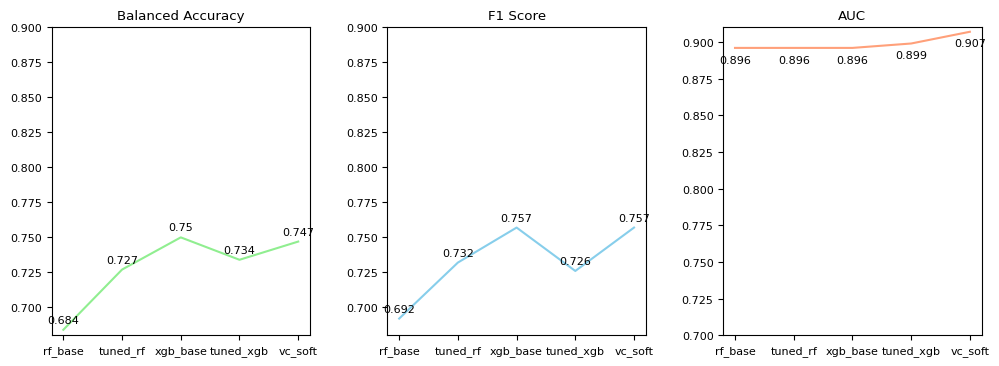

In [ ]:
# Plot the performance of all five models
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
plt.subplots_adjust(wspace = 0.3)

# Extract x-ticks and model names
x_ticks = range(len(performance['Model']))
models = performance['Model'].to_list()

# Plot Balanced Accuracy
axs[0].plot(x_ticks, performance['Balanced Accuracy'], linestyle = '-', color = 'lightgreen')
axs[0].set_title('Balanced Accuracy')
axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(models)
axs[0].set_ylim(0.68, 0.9)
y1 = performance['Balanced Accuracy'].to_list()
for i, y in enumerate(y1):
    axs[0].text(i, y+0.005, f'{y}', ha = 'center')

# Plot F1 Score
axs[1].plot(x_ticks, performance['F1 Score'], linestyle = '-', color = 'skyblue')
axs[1].set_title('F1 Score')
axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(models)
axs[1].set_ylim(0.68,0.9)
y2 = performance['F1 Score'].to_list()
for i, y in enumerate(y2):
    axs[1].text(i, y+0.005, f'{y}', ha = 'center')

# Plot AUC Score
axs[2].plot(x_ticks, performance['AUC'], linestyle = '-', color = 'lightsalmon')
axs[2].set_title('AUC')
axs[2].set_xticks(x_ticks)
axs[2].set_xticklabels(models)
axs[2].set_ylim(0.70, 0.91)
y3 = performance['AUC'].to_list()
for i, y in enumerate(y3):
    axs[2].text(i, y-0.01, f'{y}', ha = 'center')

From the performance plots above, we can see that 'xgb_base' and 'vc_soft' perform better than the others. The performance of these two models is very close: they have the same F1 score; 'xgb_base' performs a bit better in balanced accuracy, and 'vc_soft' performs a bit better in AUC.

It's also noticeable that the AUC scores in all models are much higher than the balanced accuracy and F1 score. This may indicate a potential issue with the model's ability to predict a certain class accurately.

Let's check the confusion matrix of 'xgb_base' and see what we can find.

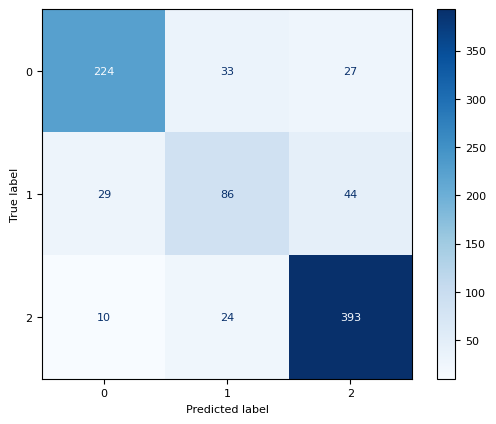

In [ ]:
cm = confusion_matrix(test_labels, xgb_base.predict(test_features), labels = xgb_base.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb_base.classes_)
disp.plot(cmap = 'Blues')
plt.show()

It looks like the model is better at distinguishing between classes 0 and 2 but is less accurate in distinguishing between classes 1 and 2, or 1 and 0. This makes sense because class 0 represents 'Dropout,' class 2 represents 'Graduate,' and class 1 represents 'Enrolled,' which is an intermediate state that can transition to either 'Dropout' or 'Graduate' later. In this sense, the intermediate state may introduce noise to the model and affect its performance.

**Second Iteration of Modeling (21 features, binary label)**

As mentioned before, our goal in this project is to predict student dropouts and identify which students need more support. Given this, will a binary classification model with only two labels, 'Dropout' and 'Graduate', perform better?

In order to find out, I will remove the intermediate class ('Enrolled') and trained the models in the same manner as in the first iteration, but with binary labels: 1 for 'Dropout' and 0 for 'Graduate’.

In [ ]:
# Remove rows of class-1 (enrolled) from training and test set
train_bi = train.drop(train[train['Target_encoded']==1].index)
test_bi = test.drop(test[test['Target_encoded']==1].index)

# Set the target label as 1 - 'Dropout', 0 - 'Graduate'
train_bi['Target_encoded'] = train_bi['Target_encoded'].replace([0, 2], [1, 0])
test_bi['Target_encoded'] = test_bi['Target_encoded'].replace([0, 2], [1, 0])

# Extract features and labels
train_bi_X = train_bi.drop('Target_encoded', axis = 1)
train_bi_y = train_bi['Target_encoded']
test_bi_X = test_bi.drop('Target_encoded', axis = 1)
test_bi_y = test_bi['Target_encoded']

In [ ]:
# Train Random Forst on the training set
rf_bi = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
rf_bi.fit(train_bi_X, train_bi_y)

y_pred = rf_bi.predict(test_bi_X)
y_prob = rf_bi.predict_proba(test_bi_X)

rf_bi_accuracy = round(balanced_accuracy_score(test_bi_y, y_pred), 3)
rf_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
rf_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('Random Forest Baseline Performance:')
print('Balanced Accuracy:', rf_bi_accuracy)
print('F1 Score:', rf_bi_f1score)
print('AUC score:', rf_bi_auc)

Random Forest Baseline Performance:
Balanced Accuracy: 0.914
F1 Score: 0.903
AUC score: 0.952


In [ ]:
# Tune hyperparameter of Random Forest
parm = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 3, 5],
    'max_samples': [0.5, 0.75, 1]
}

# Search for best hyperparameters combination
rsv_rf_bi = RandomizedSearchCV( estimator = RandomForestClassifier(class_weight = 'balanced',
                                                                   random_state = 42),
                                param_distributions = parm, scoring = 'balanced_accuracy',
                                n_iter = 30, n_jobs = -1,  random_state = 0)

rsv_rf_bi.fit(train_bi_X, train_bi_y)

# Get the best estimator
tuned_rf_bi = rsv_rf_bi.best_estimator_

# Check the model performance
y_pred = tuned_rf_bi.predict(test_bi_X)
y_prob = tuned_rf_bi.predict_proba(test_bi_X)

tuned_rf_bi_accuracy = round(balanced_accuracy_score(test_bi_y, y_pred), 3)
tuned_rf_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
tuned_rf_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('tuned_rf_bi Performance:')
print('Balanced Accuracy:', tuned_rf_bi_accuracy)
print('F1 Score:', tuned_rf_bi_f1score)
print('AUC score:', tuned_rf_bi_auc)

tuned_rf_bi Performance:
Balanced Accuracy: 0.917
F1 Score: 0.906
AUC score: 0.956


In [ ]:
# Train XGBClassifier
neg_num = sum(train_bi_y == 0)
pos_num = sum(train_bi_y == 1)
weight = neg_num / pos_num

xgb_bi = XGBClassifier(enable_categorical = True, scale_pos_weight = weight,
                       importance_type = 'gain', random_state = 42)
xgb_bi.fit(train_bi_X, train_bi_y)

y_pred = xgb_bi.predict(test_bi_X)
y_prob = xgb_bi.predict_proba(test_bi_X)

xgb_bi_accuracy = round(balanced_accuracy_score(test_bi_y, y_pred), 3)
xgb_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
xgb_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('xgb_bi performance:')
print('Balanced accuracy:', xgb_bi_accuracy)
print('F1 score:', xgb_bi_f1score)
print('AUC score:', xgb_bi_auc)

xgb_bi performance:
Balanced accuracy: 0.923
F1 score: 0.911
AUC score: 0.956


In [ ]:
# Tune the hyperparameters of XGBClassifier
param = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 8],
    'min_child_weight': [1, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.5, 0.8]
}

rsv_xgb_bi = RandomizedSearchCV(estimator = XGBClassifier(enable_categorical = True,
                                                          scale_pos_weight = weight,
                                                          random_state = 42),
                                param_distributions = param, scoring = 'balanced_accuracy',
                                n_iter= 50, n_jobs = -1, random_state = 6)

rsv_xgb_bi.fit(train_bi_X, train_bi_y)

# Extract best estimator
tuned_xgb_bi = rsv_xgb_bi.best_estimator_

# Check 'tuned_xgb_bi' performance
y_pred = tuned_xgb_bi.predict(test_bi_X)
y_prob = tuned_xgb_bi.predict_proba(test_bi_X)

tuned_xgb_bi_accuracy = round(balanced_accuracy_score(test_bi_y, y_pred), 3)
tuned_xgb_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
tuned_xgb_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('tuned_xgb_bi performance:')
print('Balanced accuracy:', tuned_xgb_bi_accuracy)
print('F1 score:', tuned_xgb_bi_f1score)
print('AUC score:', tuned_xgb_bi_auc)

tuned_xgb_bi performance:
Balanced accuracy: 0.921
F1 score: 0.908
AUC score: 0.962


In [ ]:
# Combine best models into VotingClassifer
vc_soft_bi = VotingClassifier(estimators = [('rf', tuned_rf_bi), ('xgb', xgb_bi)],
                              voting = 'soft')
vc_soft_bi.fit(train_bi_X, train_bi_y)

y_pred = vc_soft_bi.predict(test_bi_X)
y_prob = vc_soft_bi.predict_proba(test_bi_X)

vc_soft_bi_accuracy = round(balanced_accuracy_score(test_bi_y, y_pred), 3)
vc_soft_bi_f1score = round(f1_score(test_bi_y, y_pred), 3)
vc_soft_bi_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('vc_soft_bi performance:')
print('Balanced accuracy:', vc_soft_bi_accuracy)
print('F1 score:', vc_soft_bi_f1score)
print('AUC score:', vc_soft_bi_auc)

vc_soft_bi performance:
Balanced accuracy: 0.921
F1 score: 0.91
AUC score: 0.959


In [ ]:
# Compare model performance
pd.DataFrame({
            'Model': ['rf_bi', 'tuned_rf_bi', 'xgb_bi', 'tuned_xgb_bi', 'vc_soft_bi'],
            'Balanced Accuracy': [rf_bi_accuracy, tuned_rf_bi_accuracy, xgb_bi_accuracy,
                                  tuned_xgb_bi_accuracy, vc_soft_bi_accuracy],
            'F1 Score': [rf_bi_f1score, tuned_rf_bi_f1score, xgb_bi_f1score,
                         tuned_xgb_bi_f1score, vc_soft_bi_f1score],
            'AUC': [rf_bi_auc, tuned_rf_bi_auc, xgb_bi_auc, tuned_xgb_bi_auc, vc_soft_bi_auc]
            })

,Model,Balanced Accuracy,F1 Score,AUC
0,rf_bi,0.914,0.903,0.952
1,tuned_rf_bi,0.917,0.906,0.956
2,xgb_bi,0.923,0.911,0.956
3,tuned_xgb_bi,0.921,0.908,0.962
4,vc_soft_bi,0.921,0.910,0.959


The performance of the five binary classification models is much better than all 3-classes models before.

'xgb_bi' and 'vc_soft_bi' performs better than the other models again, and their performances are also very close: 'xgb_bi' performs slightly better than vc_soft_bi' in terms of balanced accuracy and F1 score, but it's AUC is a bit lower than that of 'vc_soft_bi'.

The hyperparameter tuning of the XGBoost didn't bring any improvement to the models, probably because I only set the number of iterations to 50 in the RandomizedSearchCV for efficiency, so it didn't reach the truly optimized parameter settings.

Feature Importance of 'vc_soft_bi'

Let's check the feature importance of 'vc_soft_bi' to see if there is any insignificant feature that we can remove. Since this VotingClassifier is combined by two models, a Random Forest model 'tuned_rf_bi' and a XGBClassifier model 'xbg_bi', I will get the feature importance scores from the two models' built-in functions and the permutation importance score of the combined model 'vc_soft_bi', then average them to get a mean importance score of all features.

**Feature Importance calculation**

In [ ]:
# Calculate feature importance
score_1 = rf_bi.feature_importances_
score_2 = xgb_bi.feature_importances_
score_3 = permutation_importance(vc_soft_bi, test_bi_X, test_bi_y, n_repeats = 10,
                                 random_state = 16).importances_mean

In [ ]:
# Normalizing score_3 to sum to 1
score_3[score_3 < 0] = 0
score_3 = score_3 / np.sum(score_3)

# Calculate importance ratio and cumulative sum of the ratio
feature_imp = pd.DataFrame({'Features': test_bi_X.columns,
                            'Importance': (score_1 + score_2 + score_3) / 3
})
feature_imp = feature_imp.sort_values(by = 'Importance', ascending = False)
feature_imp['Imp_ratio'] = feature_imp['Importance'] / feature_imp['Importance'].sum()
feature_imp['cum_ratio'] = feature_imp['Imp_ratio'].cumsum()

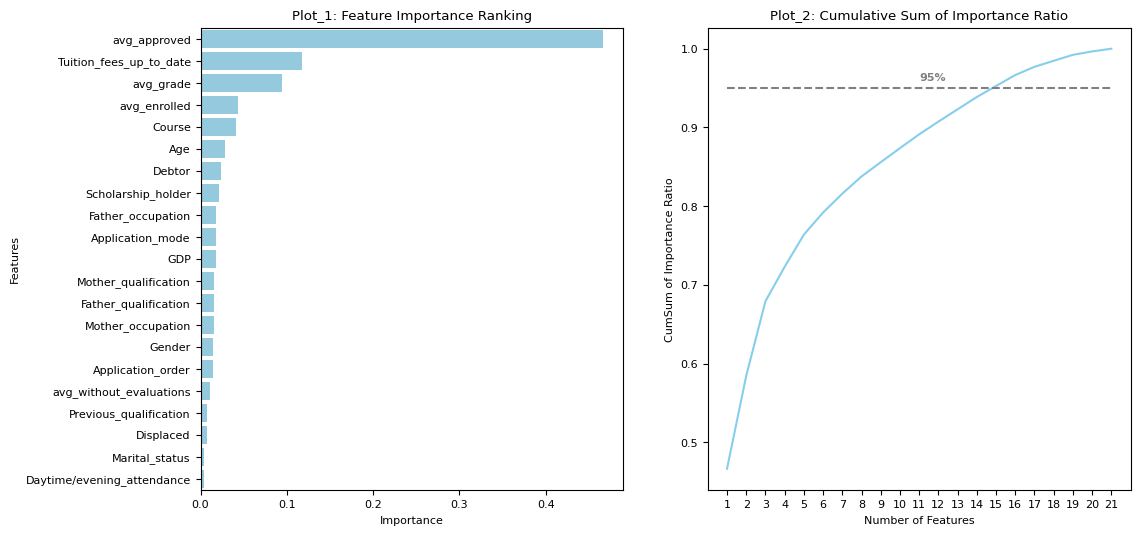

In [ ]:
# Plot feature importance ranking and cumulative sum of importance ratio
n = len(feature_imp)

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
ax1 = sns.barplot(data = feature_imp, x = 'Importance', y = 'Features',
                  color = 'skyblue', ax = ax1)
ax1.set_title('Plot_1: Feature Importance Ranking')

ax2.plot(range(1, n+1), feature_imp['cum_ratio'], color = 'skyblue')
ax2.plot(range(1, n+1), np.repeat(0.95, n), color = 'grey', linestyle = 'dashed')
ax2.text(11, 0.96, '95%', color = 'grey', fontweight = 'bold')
ax2.set_title('Plot_2: Cumulative Sum of Importance Ratio')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('CumSum of Importance Ratio')
ax2.set_xticks(range(1, len(feature_imp)+1), range(1, len(feature_imp)+1));

Plot_1 shows the ranking of feature importance, while Plot_2 shows the cumulative sum of importance ratios from the first to the last feature in the ranking. Clearly, not all features are equally important, with some contributing very little based on the average importance score. The gray dashed line in Plot_2 indicates when the cumulative sum of importance ratios reaches 95% of the total importance, which corresponds to 15 features.

From Plot_1, we can see that the 15th feature is 'Gender,' and its importance score is nearly identical to that of 'Application_order,' the 16th feature, indicating that these two features are almost equal in importance.

I will remove the last five features and keep the first 16 to retrain the model.

**Third Iteration of Modeling (16 features, binary label)**

In [ ]:
# Remove the last five features from the training and test set
least_imp = feature_imp['Features'][-5:].to_list()
train_16X = train_bi_X.drop(columns = least_imp)
test_16X = test_bi_X.drop(columns = least_imp)

In [ ]:
# Train Random forest with 16 features
rf_b16 = RandomForestClassifier(class_weight = 'balanced', random_state = 48)

rf_b16.fit(train_16X, train_bi_y)

y_pred = rf_b16.predict(test_16X)
y_prob = rf_b16.predict_proba(test_16X)

rf_b16_accuracy = round(balanced_accuracy_score(test_bi_y, y_pred), 3)
rf_b16_f1score = round(f1_score(test_bi_y, y_pred), 3)
rf_b16_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('rf_b16 Performance:')
print('Balanced Accuracy:', rf_b16_accuracy)
print('F1 Score:', rf_b16_f1score)
print('AUC score:', rf_b16_auc)

rf_b16 Performance:
Balanced Accuracy: 0.919
F1 Score: 0.91
AUC score: 0.955


In [ ]:
# Train XGBClassifier with 16 features
xgb_b16 = XGBClassifier(enable_categorical = True, scale_pos_weight = 1.65,
                        importance_type = 'gain', random_state = 48)
xgb_b16.fit(train_16X, train_bi_y)

y_pred = xgb_b16.predict(test_16X)
y_prob = xgb_b16.predict_proba(test_16X)

xgb_b16_accuracy = round(balanced_accuracy_score(test_bi_y, y_pred), 3)
xgb_b16_f1score = round(f1_score(test_bi_y, y_pred), 3)
xgb_b16_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('xgb_b16 performance:')
print('Balanced accuracy:', xgb_b16_accuracy)
print('F1 score:', xgb_b16_f1score)
print('AUC score:', xgb_b16_auc)

xgb_b16 performance:
Balanced accuracy: 0.924
F1 score: 0.913
AUC score: 0.958


In [ ]:
# Combine the two models into VotingClassifier
vc_b16 = VotingClassifier(estimators = [('rf', rf_b16), ('xgb', xgb_b16)], voting = 'soft')

vc_b16.fit(train_16X, train_bi_y)

y_pred = vc_b16.predict(test_16X)
y_prob = vc_b16.predict_proba(test_16X)

vc_b16_accuracy = round(balanced_accuracy_score(test_bi_y, y_pred), 3)
vc_b16_f1score = round(f1_score(test_bi_y, y_pred), 3)
vc_b16_auc = round(roc_auc_score(test_bi_y, y_prob[:, 1]), 3)

print('vc_b16 performance:')
print('Balanced accuracy:', vc_b16_accuracy)
print('F1 score:', vc_b16_f1score)
print('AUC score:', vc_b16_auc)

vc_b16 performance:
Balanced accuracy: 0.93
F1 score: 0.921
AUC score: 0.959


In [ ]:
pd.DataFrame({
    'Model': ['rf_b16', 'xgb_b16', 'vc_b16'],
    'Balanced Accuracy': [rf_b16_accuracy, xgb_b16_accuracy, vc_b16_accuracy],
    'F1 Score': [rf_b16_f1score, xgb_b16_f1score, vc_b16_f1score],
    'AUC': [rf_b16_auc, xgb_b16_auc, vc_b16_auc]
})

,Model,Balanced Accuracy,F1 Score,AUC
0,rf_b16,0.919,0.910,0.955
1,xgb_b16,0.924,0.913,0.958
2,vc_b16,0.930,0.921,0.959


The Voting Classifier 'vc_b16' achieved a balanced accuracy of 0.93, an F1 score of 0.921 and an AUC score of 0.959, making it the best model among all those we've built.

#Results and Analysis
Let's put the performance of the best model in each iteration together and visualize the results.

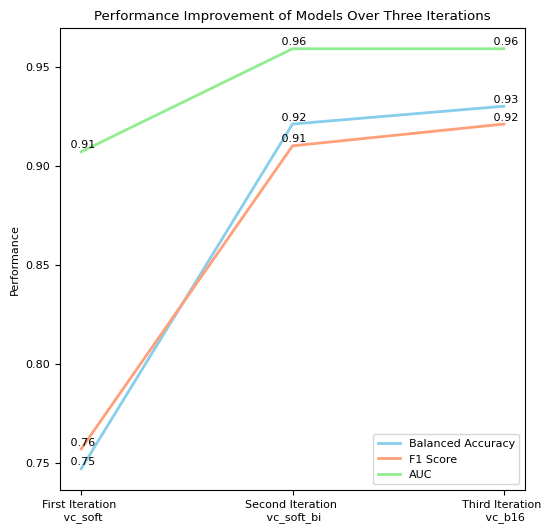

In [ ]:
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create a dataframe for the performance of the best model in each iteration
results = pd.DataFrame({
    'Models': ['vc_soft', 'vc_soft_bi', 'vc_b16', 'vc_soft', 'vc_soft_bi',
               'vc_b16', 'vc_soft', 'vc_soft_bi', 'vc_b16'],
    'Metrics': ['Balanced Accuracy', 'Balanced Accuracy', 'Balanced Accuracy',
                'F1 Score', 'F1 Score', 'F1 Score', 'AUC', 'AUC', 'AUC'],
    'Performance': [vc_soft_accuracy, vc_soft_bi_accuracy, vc_b16_accuracy,
                    vc_soft_f1score, vc_soft_bi_f1score, vc_b16_f1score,
                    vc_soft_auc, vc_soft_bi_auc, vc_b16_auc]
})

# Visualize the performance improvement of models over three iterations
plt.figure(figsize = (6, 6))
xticks = range(len(results['Models'].unique()))
mods = ['First Iteration \n vc_soft', 'Second Iteration \n vc_soft_bi',
        'Third Iteration \n vc_b16']
ax = sns.lineplot(data = results, x = 'Models', y = 'Performance', hue = 'Metrics',
                  palette = ['skyblue', 'lightsalmon', 'lightgreen'], linewidth = 2)
ax.set_xticks(xticks)
ax.set_xticklabels(mods)
ax.set_xlabel('')

for x, y in zip([0, 1, 2] * 3, results['Performance']):
    ax.text(x, y + 0.002, f'{y: .2f}', ha = 'center')

ax.set_title('Performance Improvement of Models Over Three Iterations')
ax.legend(title = '', loc = 'lower right');

Across three iterations, with evolving class numbers (from 3 to binary) and feature sets (from 21 to 16), model performance improved significantly. Balanced accuracy jumped from 0.75 to 0.93 (an increase of 24%), F1-score rose from 0.76 to 0.92 (an increase of 21%), and AUC increased from 0.91 to 0.96 (an increase of 5%), indicating substantial gains in classification accuracy.

Our final model is ‘vc_b16’.

**Visualizing Top Features in the Final Model**

Now let's examine the feature importance of the final model, 'vc_b16'.

In [ ]:
# Calculate the importance score and normalize s3 to sum to 1 as what I did before
s1 = rf_b16.feature_importances_
s2 = xgb_b16.feature_importances_
s3 = permutation_importance(vc_b16, test_16X, test_bi_y, n_repeats = 10,
                            random_state = 20).importances_mean
s3 = s3 / np.sum(s3)

imp = pd.DataFrame({
    'Features': test_16X.columns,
    'Importance': (s1 + s2 + s3)/3
})

imp = imp.sort_values(by = 'Importance', ascending = False)

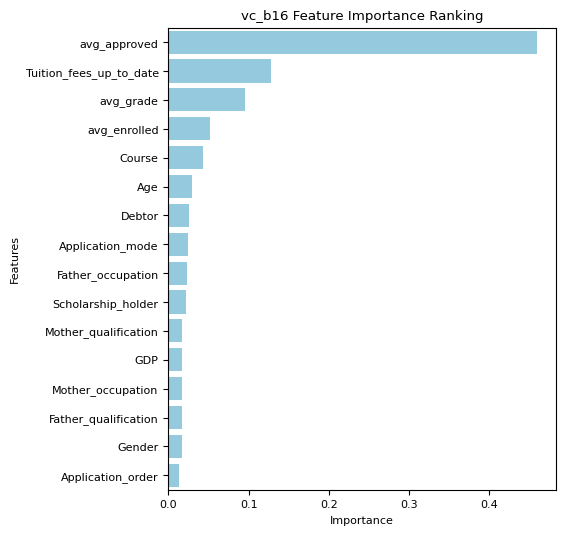

In [ ]:
# Plot the ranking of feature importance
plt.figure(figsize = (5, 6))
sns.barplot(data = imp, x = 'Importance', y = 'Features', color = 'skyblue')
plt.title('vc_b16 Feature Importance Ranking');

The most important features are 'curri_avg_approved,' 'Tuition_fees_up_to_date,' and 'curri_avg_grade,' followed by 'curri_avg_enrolled,' 'Course,' and 'Age'. Among these top features, four are academic data, one is socioeconomic data, and one is demographic data.

Let's see how these features influence whether students drop out or graduate.

In [ ]:
# Extract the necessary features from the entire dataset for further analysis.
cols = train_16X.columns.to_list()
cols.append('Target_encoded')

stud = stud_selected.loc[:, cols]
stud['Target_encoded'] = stud['Target_encoded'].replace([0, 1, 2],
                                                        ['Drop Out', 'Enrolled', 'Graduate'])
stud['Gender'] = stud['Gender'].replace([0, 1], ['Female', 'Male'])
stud['Tuition_fees_up_to_date'] = stud['Tuition_fees_up_to_date'].replace([0, 1], ['No', 'Yes'])
stud.rename(columns = {'Target_encoded': 'Target'}, inplace = True)

# Replace course values with the course name(hypothetical)
course_lst = ['Biofuel Production Technologies', 'Animation and Multimedia Design',
              'Social Service (evening attendance)', 'Agronomy', 'Communication Design',
              'Veterinary Nursing', 'Informatics Engineering', 'Equiniculture',
              'Management', 'Social Service', 'Tourism', 'Nursing', 'Oral Hygiene',
              'Advertising and Marketing Management', 'Journalism and Communication',
              'Basic Education', 'Management (evening attendance)']
stud['Course'] = stud['Course'].replace(list(range(1, 18)), course_lst)

We already observed how 'curri_avg_approved' and 'curri_avg_grade' are associated with students' situations ('Dropout', 'Enrolled', or 'Graduate') at the end of the course during the Exploratory Data Analysis. Now, let's examine the three important curricular units related variables focusing on the two labels, 'Dropout' and 'Graduate', only.

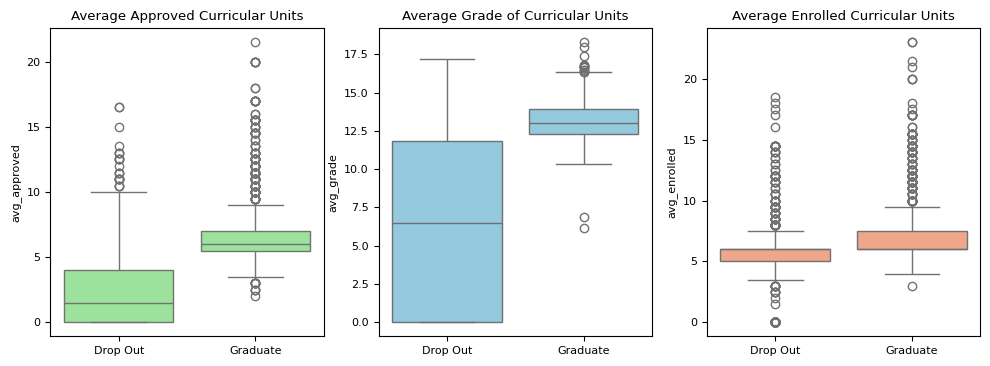

In [ ]:
# Plot the three curricular units related variables
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
sns.boxplot(data = stud.loc[(stud['Target'] == 'Drop Out') | (stud['Target'] == 'Graduate')],
            x = 'Target', y = 'avg_approved', color = 'lightgreen', ax = ax1)
ax1.set_title('Average Approved Curricular Units')
ax1.set_xlabel("")

sns.boxplot(data = stud.loc[(stud['Target'] == 'Drop Out') | (stud['Target'] == 'Graduate')],
            x = 'Target', y = 'avg_grade', color = 'skyblue', ax = ax2)
ax2.set_title('Average Grade of Curricular Units')
ax2.set_xlabel("")

sns.boxplot(data = stud.loc[(stud['Target'] == 'Drop Out') | (stud['Target'] == 'Graduate')],
            x = 'Target', y = 'avg_enrolled', color = 'lightsalmon', ax = ax3)
ax3.set_title('Average Enrolled Curricular Units')
ax3.set_xlabel("");

Students who graduate at the end of the normal duration of the course have much more approved curricular units and much higher average grade in the first and second semester compared to those who drop out.

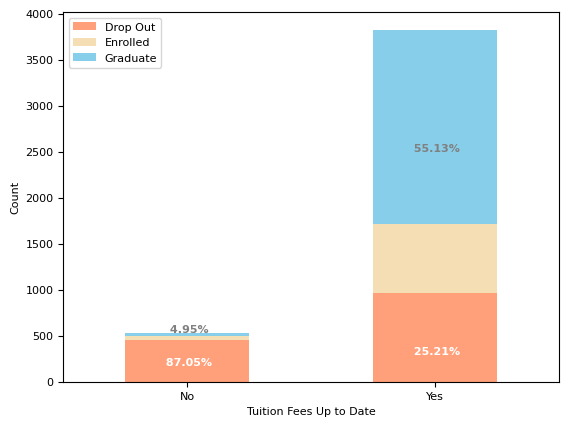

In [ ]:
# Create the cross table of 'Tuition_fees_up_to_date' vs. 'Target'
tuition = pd.crosstab(stud['Tuition_fees_up_to_date'], stud['Target'])

# Normalize the cross table to get the percentage
tuition_pct = tuition.div(tuition.sum(1), axis = 0) * 100

# Plot the cross table of 'Tuition_fees_up_to_date' vs. 'Target'
tuition.plot(kind = 'bar', stacked = True, color = ['lightsalmon', 'wheat', 'skyblue'])
plt.legend(title = '')
plt.tick_params(axis = 'x', rotation = 0)
plt.ylabel('Count')
plt.xlabel('Tuition Fees Up to Date')
plt.text(0, 180, f"{tuition_pct.loc['No', 'Drop Out']: .2f}%",
         ha = 'center', color = 'white', fontweight = 'bold')
plt.text(0, 530, f"{tuition_pct.loc['No', 'Graduate']: .2f}%",
         ha = 'center', color = 'grey', fontweight = 'bold')
plt.text(1, 300, f"{tuition_pct.loc['Yes', 'Drop Out']: .2f}%",
         ha = 'center', color = 'white', fontweight = 'bold')
plt.text(1, 2500, f"{tuition_pct.loc['Yes', 'Graduate']: .2f}%",
         ha = 'center', color = 'grey', fontweight = 'bold');

Students whose tuition fees are not up to date have a very high dropout rate of 87.05% and a very low graduation rate of 4.95%.

The 'Age' variable ranges from 17 to 70 in the dataset. I will divide it into four age groups and then visualize the dropout rate by age group and gender.

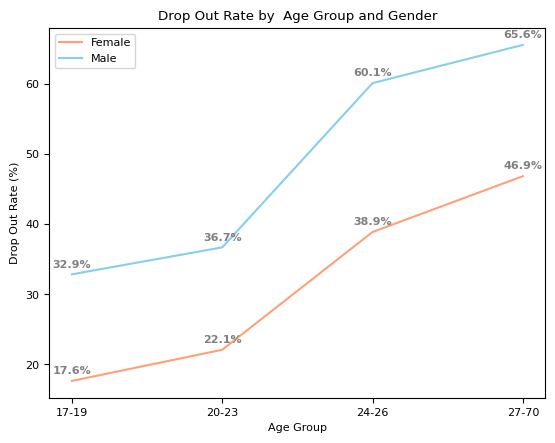

In [ ]:
# Create cross tables for different age groups vs. target
age17_19 = pd.crosstab(stud.loc[stud['Age'] < 20]['Gender'],
                       stud.loc[stud['Age'] < 20]['Target'])
age17_19 = age17_19.div(age17_19.sum(1), axis = 0) * 100

age20_23 = pd.crosstab(stud.loc[(stud['Age'] > 19) & (stud['Age'] < 24)]['Gender'],
                       stud.loc[(stud['Age'] > 19) & (stud['Age'] < 24)]['Target'])
age20_23 = age20_23.div(age20_23.sum(1), axis = 0) * 100

age24_26 = pd.crosstab(stud.loc[(stud['Age'] > 23) & (stud['Age'] < 27)]['Gender'],
                       stud.loc[(stud['Age'] > 23) & (stud['Age'] < 27)]['Target'])
age24_26 = age24_26.div(age24_26.sum(1), axis = 0) * 100

age27_70 = pd.crosstab(stud.loc[stud['Age'] > 27]['Gender'],
                       stud.loc[stud['Age'] > 27]['Target'])
age27_70 = age27_70.div(age27_70.sum(1), axis = 0) * 100

# Create a dataframe of Drop Out Rate by Age Group and Gender
age_gen = pd.DataFrame({
    'Age Group': ['17-19', '17-19', '20-23', '20-23', '24-26', '24-26', '27-70', '27-70'],
    'Gender': ['Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male'],
    'Drop Out Rate (%)': [age17_19.loc['Female', 'Drop Out'], age17_19.loc['Male', 'Drop Out'],
                      age20_23.loc['Female', 'Drop Out'], age20_23.loc['Male', 'Drop Out'],
                      age24_26.loc['Female', 'Drop Out'], age24_26.loc['Male', 'Drop Out'],
                      age27_70.loc['Female', 'Drop Out'], age27_70.loc['Male', 'Drop Out']]
})

# Plot Drop Out Rate by  Age Group and Gende
ax = sns.lineplot(data = age_gen, x = 'Age Group', y = 'Drop Out Rate (%)',
                  hue = 'Gender', palette = ['lightsalmon', 'skyblue'])

for x, y in zip(age_gen['Age Group'], age_gen['Drop Out Rate (%)']):
    ax.text(x, y+1, f'{y:.1f}%', horizontalalignment = 'center',
            color = 'grey', fontweight = 'bold')

ax.set_title('Drop Out Rate by  Age Group and Gender')
ax.legend(title = '')
plt.show()

The dropout rates of both females and males increase with age, but females consistently have lower dropout rates across all age groups, suggesting that both age and gender are important factors influencing students' likelihood of dropping out.

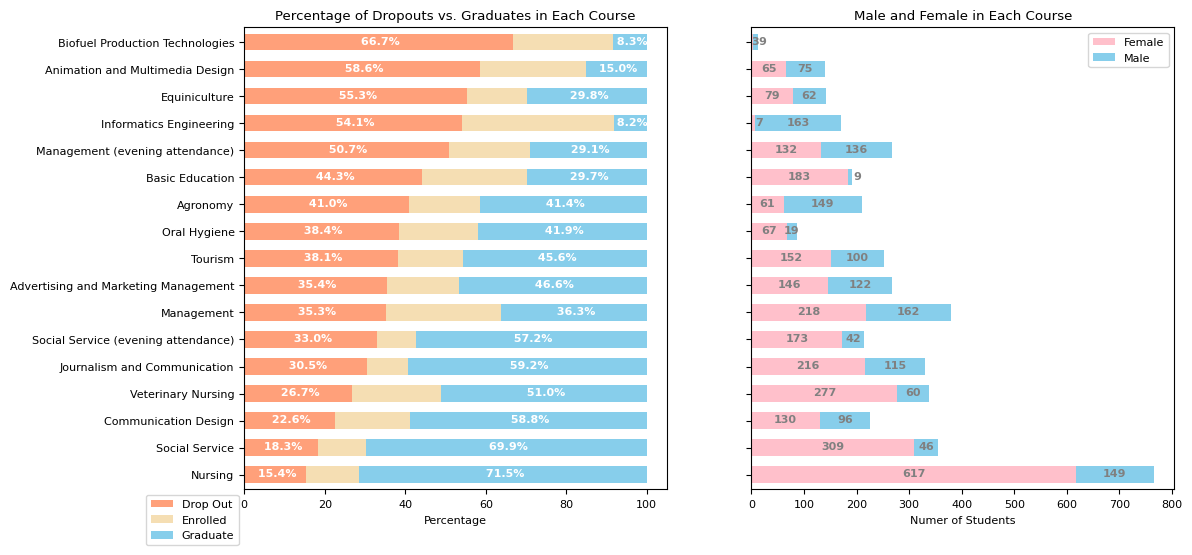

In [ ]:
# Create cross table of Course vs. Target
course = pd.crosstab(stud['Course'], stud['Target'])

# Normalize the table to get percentage
course = course.div(course.sum(1), axis = 0) * 100

# Sort the cross table by 'Drop Out'
course = course.sort_values(by = 'Drop Out')

# Plot percentage of dropouts vs. graduates in each course
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6), sharey = True)

colors = ['lightsalmon', 'wheat', 'skyblue']
course.plot(kind = 'barh', stacked = True, color = colors, width = 0.6, ax = ax1)
ax1.legend(title = '', bbox_to_anchor = (0, 0))
ax1.set_title('Percentage of Dropouts vs. Graduates in Each Course')
ax1.set_xlabel('Percentage')
ax1.set_ylabel('');

# Add percentage labels to the plot
label_1 = list(range(0, 17))
label_3 = list(range(34, 52))
for i, p in enumerate(ax1.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if i in label_1:
        ax1.annotate(f'{width: .1f}%', (x + width/2, y + height/2.5),
                     ha = 'center', color = 'white', fontweight = 'bold')
    elif i in label_3:
        ax1.annotate(f'{width: .1f}%', (x + width/2, y + height/2.5),
                     ha = 'center', color = 'white', fontweight = 'bold')

# Count number of females and males in each course
num_stud = pd.crosstab(stud['Course'], stud['Gender']).reindex(course.index.to_list())

# Plot number of students in each course
num_stud.plot(kind = 'barh', stacked = True, color = ['pink', 'skyblue'], width = 0.6, ax = ax2)
for p in ax2.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if width < 10:
        ax2.annotate(f'{int(width)}', (x + width * 2, y + height/2.5),
                     ha = 'center', color = 'grey', fontweight = 'semibold')
    else:
        ax2.annotate(f'{int(width)}', (x + width/2, y + height/2.5),
                     ha = 'center', color = 'grey', fontweight = 'semibold')

ax2.legend(title = '')
ax2.set_ylabel('')
ax2.set_xlabel('Numer of Students')
ax2.set_title('Male and Female in Each Course')

plt.show()

The dropout rates in different courses range from 15.4% to 66.7%. Five out of 17 courses have dropout rates exceeding 50%.
                  
In this dataset, there are more females than males, resulting in a predominance of female students in most courses. While enrollments vary across different courses, the proportions of female and male students also differ, suggesting that factors beyond gender contribute to dropout rates.

**Probability of Dropping Out in the Simulated Dataset**

I will simulate three datasets—'grade,' 'approved,' and 'age'—and predict the probability of dropping out using the final model. This will allow me to see how the values of 'curri_avg_grade', 'curri_avg_approved' , and 'Age'  impact the probability of dropping out, while keeping all other features constant (taking the mean for numeric data and the mode for categorical data).

# Simulating the Impact of Average Grade on Dropout Probability
In this section, I created a simulated dataset to isolate the effect of a student's average grade on dropout probability. I held most features constant—such as application mode, course, and parental background—using their most frequent values. This created a controlled environment, allowing me to focus solely on how changes in average grade influence dropout risk.

I systematically varied average grades from 0 to 20, repeating each value four times to account for gender and tuition payment status differences. This ensured a broad and balanced representation.

Using np.repeat() and the pre-trained model (vc_b16), I predicted dropout probabilities across the simulated records. This approach provided clear insights into how academic performance alone impacts dropout risk, free from the noise of other confounding factors.

In [ ]:
# Simulated dataset -- 'grade'
grade = pd.DataFrame({
    'Application_mode': np.repeat(stud_selected['Application_mode'].mode()[0], 84),
    'Application_order': np.repeat(stud_selected['Application_order'].mode()[0], 84),
    'Course': np.repeat(stud_selected['Course'].mode()[0], 84),
    'Mother_qualification': np.repeat(stud_selected['Mother_qualification'].mode()[0], 84),
    'Father_qualification': np.repeat(stud_selected['Father_qualification'].mode()[0], 84),
    'Mother_occupation': np.repeat(stud_selected['Mother_occupation'].mode()[0], 84),
    'Father_occupation': np.repeat(stud_selected['Father_occupation'].mode()[0], 84),
    'Debtor': np.repeat(stud_selected['Debtor'].mode()[0], 84),
    'Tuition_fees_up_to_date': np.repeat([0, 0, 1, 1], 21),
    'Gender': np.repeat([0, 1, 0, 1], 21),
    'Scholarship_holder': np.repeat(stud_selected['Scholarship_holder'].mode()[0], 84),
    'Age': np.repeat(round(stud_selected['Age'].mean()), 84),
    'GDP': np.repeat(stud_selected['GDP'].mean(), 84),
    'avg_enrolled': np.repeat(round(stud_selected['avg_enrolled'].mean()), 84),
    'avg_approved': np.repeat(round(stud_selected['avg_approved'].mean()), 84),
    'avg_grade': list(range(0, 21)) * 4
})

# Predict drop out probability
grade['dropout_proba'] = vc_b16.predict_proba(grade)[:, 1]

# Modify the table
grade['Gender'] = grade['Gender'].replace([1, 0], ['Male', 'Female'])
grade['Tuition_fees_up_to_date'] = grade['Tuition_fees_up_to_date'].replace([1, 0],
                                   ['Tuition_up_to_date', 'Tuition_NOT_up_to_date'])
grade['Gen_Tui'] = grade[['Gender', "Tuition_fees_up_to_date"]].agg('_'.join, axis = 1)

# Simulating the impact of average number of approved courses on dropout probability
In this section, I created a simulated dataset to isolate the impact of a student's average number of approved courses on dropout probability. I held all other features constant—using the most common or average values from the original dataset—to create a controlled environment where the primary variable of interest was avg_approved.

I varied avg_approved systematically from 0 to 25, repeating each value across four combinations of gender and tuition payment status. This ensured a comprehensive view of how approval count interacts with key student demographics.

Using np.repeat() and the trained model (vc_b16), I predicted dropout probabilities for each simulated record. I also formatted the gender and tuition variables into readable labels and combined them into a new column Gen_Tui for easier analysis.

In [ ]:
# Simulated dataset -- 'approved'
approved = pd.DataFrame({
    'Application_mode': np.repeat(stud_selected['Application_mode'].mode()[0], 104),
    'Application_order': np.repeat(stud_selected['Application_order'].mode()[0], 104),
    'Course': np.repeat(stud_selected['Course'].mode()[0], 104),
    'Mother_qualification': np.repeat(stud_selected['Mother_qualification'].mode()[0], 104),
    'Father_qualification': np.repeat(stud_selected['Father_qualification'].mode()[0], 104),
    'Mother_occupation': np.repeat(stud_selected['Mother_occupation'].mode()[0], 104),
    'Father_occupation': np.repeat(stud_selected['Father_occupation'].mode()[0], 104),
    'Debtor': np.repeat(stud_selected['Debtor'].mode()[0], 104),
    'Tuition_fees_up_to_date': np.repeat([0, 0, 1, 1], 26),
    'Gender': np.repeat([0, 1, 0, 1], 26),
    'Scholarship_holder': np.repeat(stud_selected['Scholarship_holder'].mode()[0], 104),
    'Age': np.repeat(round(stud_selected['Age'].mean()), 104),
    'GDP': np.repeat(stud_selected['GDP'].mean(), 104),
    'avg_enrolled': np.repeat(round(stud_selected['avg_enrolled'].mean()), 104),
    'avg_approved': list(range(0, 26)) * 4,
    'avg_grade': np.repeat(round(stud_selected['avg_grade'].mean()), 104)
})

# Predict dropout rate
approved['dropout_proba'] = vc_b16.predict_proba(approved)[:, 1]

# Modify the table
approved['Gender'] = approved['Gender'].replace([1, 0], ['Male', 'Female'])
approved['Tuition_fees_up_to_date'] = approved['Tuition_fees_up_to_date'].replace([1, 0],
                                      ['Tuition_up_to_date', 'Tuition_NOT_up_to_date'])
approved['Gen_Tui'] = approved[['Gender', "Tuition_fees_up_to_date"]].agg('_'.join, axis = 1)

# Simulating the impact of student's age influence on dropout probability
In this section, I created a simulated dataset to explore how a student’s age influences their likelihood of dropping out. To isolate the effect of age, I held all other variables constant by using the most frequent or average values from the original dataset. This ensured a controlled environment where the only changing variable was Age.

I systematically varied age from 17 to 70, repeating each value across four combinations of gender and tuition payment status. This setup allowed me to examine how dropout probability changes with age across different student demographics.

Using np.repeat() and the trained model (vc_b16), I predicted dropout probabilities for each simulated student. I also formatted gender and tuition status into readable categories and combined them into a new column Gen_Tui for easier comparison.

In [ ]:
# Simulated dataset -- 'age'
age = pd.DataFrame({
    'Application_mode': np.repeat(stud_selected['Application_mode'].mode()[0], 216),
    'Application_order': np.repeat(stud_selected['Application_order'].mode()[0], 216),
    'Course': np.repeat(stud_selected['Course'].mode()[0], 216),
    'Mother_qualification': np.repeat(stud_selected['Mother_qualification'].mode()[0], 216),
    'Father_qualification': np.repeat(stud_selected['Father_qualification'].mode()[0], 216),
    'Mother_occupation': np.repeat(stud_selected['Mother_occupation'].mode()[0], 216),
    'Father_occupation': np.repeat(stud_selected['Father_occupation'].mode()[0], 216),
    'Debtor': np.repeat(stud_selected['Debtor'].mode()[0], 216),
    'Tuition_fees_up_to_date': np.repeat([0, 0, 1, 1], 54),
    'Gender': np.repeat([0, 1, 0, 1], 54),
    'Scholarship_holder': np.repeat(stud_selected['Scholarship_holder'].mode()[0], 216),
    'Age': list(range(17, 71)) * 4,
    'GDP': np.repeat(stud_selected['GDP'].mean(), 216),
    'avg_enrolled': np.repeat(round(stud_selected['avg_enrolled'].mean()), 216),
    'avg_approved': np.repeat(round(stud_selected['avg_approved'].mean()), 216),
    'avg_grade': np.repeat(round(stud_selected['avg_grade'].mean()), 216)
})

# Predict dropout rate
age['dropout_proba'] = vc_b16.predict_proba(age)[:, 1]

# Modify the table
age['Gender'] = age['Gender'].replace([1, 0], ['Male', 'Female'])
age['Tuition_fees_up_to_date'] = age['Tuition_fees_up_to_date'].replace([1, 0],
                                ['Tuition_up_to_date', 'Tuition_NOT_up_to_date'])
age['Gen_Tui'] = age[['Gender', "Tuition_fees_up_to_date"]].agg('_'.join, axis = 1)

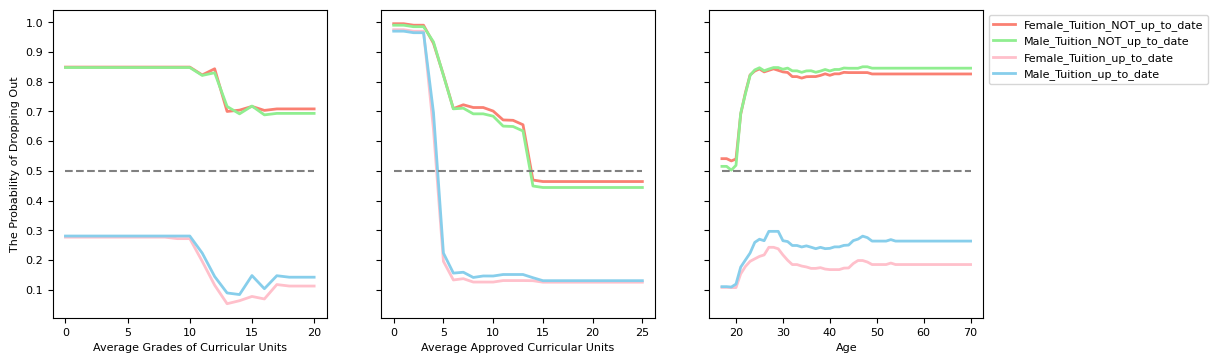

In [ ]:
# Plot the probability of dropping out based on the three simulated datasets
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4), sharey = True)
plt.subplots_adjust(wspace = 0.2)
pal = ['salmon', 'lightgreen', 'pink', 'skyblue']

# First plot: 'Average Grades of Curricular Units in 1st and 2nd Semesters'
sns.lineplot(data = grade, x = 'avg_grade', y = 'dropout_proba', hue = 'Gen_Tui',
             linewidth = 2, palette = pal, legend = False, ax = ax1)

ax1.set_xlabel('Average Grades of Curricular Units')
ax1.set_ylabel('The Probability of Dropping Out')
ax1.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax1.plot(list(range(0,21)), np.repeat(0.5, 21), color = 'grey', linestyle = 'dashed');

# Second plot: 'Average Approved Curricular Units in 1st and 2nd Semesters'
sns.lineplot(data = approved, x = 'avg_approved', y = 'dropout_proba', hue = 'Gen_Tui',
             linewidth = 2, palette = pal, legend = False, ax = ax2)

ax2.set_xlabel('Average Approved Curricular Units')
ax2.set_ylabel('')
ax2.plot(list(range(0,26)), np.repeat(0.5, 26), color = 'grey', linestyle = 'dashed');

# Third plot: 'Age'
sns.lineplot(data = age, x = 'Age', y = 'dropout_proba', hue = 'Gen_Tui',
             linewidth = 2, palette = pal, ax = ax3)

ax3.legend(title = '', bbox_to_anchor = (1, 1))
ax3.set_ylabel('')
ax3.plot(list(range(17,71)), np.repeat(0.5, 54), color = 'grey', linestyle = 'dashed');

The simulated datasets provide strong evidence that tuition payment status is a key driver of dropout risk in our final model. Across nearly all scenarios, students with unpaid tuition consistently show a predicted dropout probability above 0.5, reinforcing the weight this feature carries.

While our analysis cannot definitively answer whether non-payment leads to disengagement or if institutions preemptively remove students for non-payment, the effect is clear either way—tuition status is a major red flag.

Beyond tuition, the simulations also revealed distinct, interpretable patterns:

* Average Grade: Dropout risk remains high when grades are below 10, then sharply declines between 10 and 13, and levels off beyond 13. This highlights a performance threshold that may trigger intervention.
* Approved Units: There are two noticeable drop points in dropout risk—once students exceed 5 approved units and again past 14. This suggests progress milestones that reduce risk substantially.
* Age at Enrollment: Students under 20 show consistently low dropout risk. However, the risk climbs quickly between ages 20 and 23, then stabilizes at a higher level beyond that.

These simulations confirm that academic performance, engagement (via course approvals), and age all influence dropout risk—but financial standing appears to be the most immediate and powerful signal the model picks up on.



#Conclusion

In this project, I developed and evaluated multiple classification models to predict student dropout and academic success. Through three iterative modeling phases, I gradually simplified the model—reducing the feature set from 21 to 16 and switching from multi-class to binary classification. These changes led to significant performance gains:

* Balanced Accuracy improved from 0.75 to 0.93 (+24%)
* F1 Score increased from 0.76 to 0.92 (+21%)
* AUC rose from 0.91 to 0.96 (+5%)

These improvements highlight a key lesson: removing noise—such as low-impact features and ambiguous labels (like 'Enrolled')—can both simplify a model and enhance its accuracy. The final model, vc_b16, proved to be the most effective and interpretable version.

**What Drives Dropout? Key Feature Insights**

To understand which factors most influence dropout, I visualized the top features identified by the final model and explored their relationships with student outcomes:

* Academic performance is a strong predictor: graduates consistently had more approved curricular units and higher average grades.
* Tuition payment status stood out as a critical factor:

  * Students with unpaid tuition had a dropout rate of 87.05% and graduation rate of just 4.95%.
  * In contrast, those who paid on time had a significantly lower dropout rate of 25.21% and a graduation rate of 55.13%.

* Age trends revealed that dropout risk increases as students get older. However, female students consistently showed lower dropout rates across all age groups.
* Course of enrollment also matters: dropout rates ranged from 15.4% to 66.7%, and five out of 17 courses had dropout rates above 50%.

**Simulated Analysis: Deeper Understanding of Dropout Risk**

To further isolate the impact of key variables, I built three simulated datasets that varied average grade, approved units, and age, while keeping other factors fixed. These simulations revealed:

* Students with unpaid tuition showed dropout probabilities above 0.5 in nearly all scenarios—confirming this as a dominant feature in the model.

* Average grade: Dropout probability drops sharply between grades 10 and 13, then levels off.

* Approved units: Significant drops in dropout risk appear when students exceed 5 and 14 units.

* Age: Risk increases noticeably as enrollment age moves from 20 to 23, then plateaus.

I’m not sure if a student's failure to pay tuition on time strongly indicates that they are likely to drop out, or if the university deregisters students from their courses when they have not paid all the required tuition fees by the specified deadlines. Nevertheless, regardless of the tuition fee factor, the patterns of dropout probability is clear in the simulated datasets

**Students Most at Risk: Who Needs Support?**
* Tuition fees not up to date

* Average grade below 10 (particularly in the first two semesters)

* Fewer than 14 approved units, especially if below 5

* Age over 23 at the time of enrollment

* Male students under these same conditions

* Students enrolled in high-risk courses (with >50% dropout rates)

This project not only resulted in a high-performing predictive model but also offered actionable insights that institutions can use to better support at-risk students—and ultimately reduce dropout rates.
